IMPORT LIB

In [3]:
import pickle
import numpy as np
import pandas as pd

#dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# clustering 
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#affichage
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import offline

CHARGEMENT emb_raw

In [3]:
with open('../data/embeddings/emb_raw.pckl', 'rb') as f:
    emb_raw = pickle.load(f)
print(len(list(emb_raw)))

32960


In [4]:
# get a list of the filenames
filenames = np.array(list(emb_raw.keys()))

# get a list of the raw embeddings
feat = np.array(list(emb_raw.values()))
feat = feat.reshape(-1,4096)

REDUCTION DIMENSION    
(PCA n=200 -> 79.2% d'explicabilité)   
(umap n=100 semble bien marcher)

In [5]:
#umap
reducer = UMAP(n_components=100, random_state=42)
x_umap = reducer.fit_transform(feat)

In [6]:
#pca
# pca = PCA(n_components=200, random_state=22)
# pca.fit(feat)
# x = pca.transform(feat)
# sum(pca.explained_variance_ratio_)

ENREGISTREMENT emb_light

In [6]:
emb_light={}
for i, name in enumerate(filenames):
    emb_light[name] = x_umap[i];

with open('emb_light.pckl', 'wb') as f:
    pickle.dump(emb_light, f)

COSIN SIMILILARITIES

In [7]:
# Calculate the cosine similarity matrix
# cosine_sim = cosine_similarity(x)
cosine_sim = cosine_similarity(x_umap)

CLUSTERING

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans.fit(x)
# kmeans.fit(x_umap)
kmeans.fit(cosine_sim)

KMeans(n_clusters=2, random_state=42)

In [9]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
        
print(f"sur {len(emb_raw)} images analysées.")
print(f"il y a {len(groups)} clusters.\n")

for i in range(len(groups)):
    print(f"Nb images dans le {i}eme cluster : {len(groups[i])}")

sur 32960 images analysées.
il y a 2 clusters.

Nb images dans le 0eme cluster : 17186
Nb images dans le 1eme cluster : 15774


REDUCTION 2D

In [10]:
# pca2 = PCA(n_components=2)
# xx = pca2.fit_transform(x)

# tsne = TSNE(n_components=2)
# xx = tsne.fit_transform(x)

umap2 = UMAP(n_components=2)
xx = umap2.fit_transform(x_umap)

ENREGISTREMENT pickle_2D

In [11]:
emb_2D={}
for i, name in enumerate(filenames):
    emb_2D[name] = xx[i];

with open('emb_2D.pckl', 'wb') as f:
    pickle.dump(emb_2D, f)

In [8]:
with open('../data/embeddings/emb_2D.pckl', 'rb') as f:
    emb_2D = pickle.load(f)

SEPARATION PAR CLUSTER ET PLOT

In [12]:
xx0 = xx[kmeans.labels_ == 0]
len(xx0)

17186

In [13]:
xx1 = xx[kmeans.labels_ == 1]
len(xx1)

15774

In [6]:
list_labels = ['0008295663177_2.400.jpg', 
               '0024000238119_14.400.jpg', 
               '0013600000745_4.400.jpg', 
               '0012000071744_7.400.jpg', 
               '0011110874245_2.400.jpg', 
               '0024000016854_3.400.jpg', 
               '0014100074120_13.400.jpg', 
               '0034000312733_5.400.jpg', 
               '0020601407893_2.400.jpg', 
               '0012000142451_7.400.jpg']

In [9]:
emb_labels = np.array([emb_2D[k] for k in list_labels])

In [16]:
xx.shape

(32960, 2)

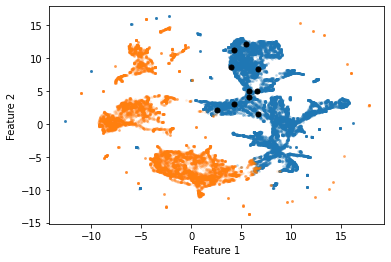

In [17]:
fig, ax = plt.subplots()

#print cluster 0 en bleu
scatter = ax.scatter(xx0[:, 0], xx0[:, 1], alpha=.2, c='C0', s=3)
#print cluster 1 en orange
ax.scatter(xx1[:, 0], xx1[:, 1], alpha=.1, c='C1', s=3)
#print liste manuelle en noir
ax.scatter(emb_labels[:, 0], emb_labels[:, 1], c='black', s=25)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

PLOT 3D

In [20]:
umap3D = UMAP(n_components=3)
xx_3 = umap3D.fit_transform(x_umap)

emb_3D={}
for i, name in enumerate(filenames):
    emb_3D[name] = xx_3[i]

with open('emb_3D.pckl', 'wb') as f:
    pickle.dump(emb_3D, f)

xx_30 = xx_3[kmeans.labels_ == 0]
xx_31 = xx_3[kmeans.labels_ == 1]

emb_labels3D = np.array([emb_3D[k] for k in list_labels])

In [39]:
emb_labels3D.shape
df_emb_labels = pd.DataFrame(emb_labels3D, columns = ['x','y','z'])
df_emb_labels['cluster'] = 2

In [55]:
df = pd.DataFrame(xx_3, columns=['x','y','z'])
df['cluster'] = kmeans.labels_
df_end = pd.concat([df, df_emb_labels])
df_end.head(15)

,x,y,z,cluster,marker_size
0,5.390545,7.921827,5.695197,1,10
1,8.150167,1.531024,-4.341098,1,10
2,-0.026869,-4.299006,2.885936,0,10
3,7.801777,4.798913,6.838837,1,10
4,8.339436,6.773459,6.687061,1,10
5,-1.395914,3.880521,6.386986,0,10
6,-7.393823,2.711697,4.309232,0,10
7,10.204473,3.270377,0.152888,1,10
8,7.599942,4.208860,6.859837,1,10
9,-1.040242,0.447058,-3.272027,0,10


In [58]:
# fig = px.scatter_3d(df, x='x', y='y', z='z',
#               color='cluster', size='cluster', size_max=18,
#               symbol='cluster', opacity=0.7)
fig = px.scatter_3d(df_end, x='x', y='y', z='z',
              color='cluster', opacity=0.6)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

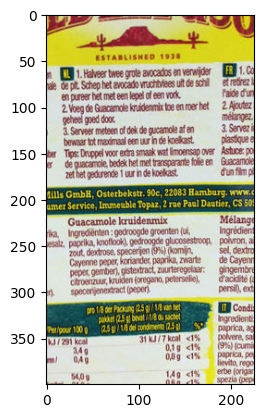

In [19]:
#[nb cluster][nb image]
file='../data/images/'+groups[0][30]
img = mpimg.imread(file)
plt.imshow(img)
plt.show()

Assignation de classe auto

In [4]:
with open('../data/embeddings/emb_light.pckl', 'rb') as f:
    emb_light = pickle.load(f)

In [5]:
emb_light_labels = np.array([emb_light[k] for k in list_labels])
emb_light_predict = kmeans.predict(emb_light_labels)
emb_light_predict

NameError: name 'list_labels' is not defined

CREATION DATAFRAME

In [ ]:
# 'ID:nom_fichier', 'class', 'etiquette', 'embeddings_proj2D'

In [261]:
dataframe=[]
for i in range(len(groups)):
    if i==0:
        for j in zip(filenames, "class_"+str(i), xx0):
            dataframe.append(j)
    else:
        for j in zip(filenames,'class_'+str(i),xx1):
            dataframe.append(j)